**Predicting price trends of digital products using various forecasting techniques: On the example of the Steam Community Marketplace**

Research questions: 
- Are machine learning methods better in predicting prices for digital goods compared to traditional methods (ARIMA,…)?
- What is the most precise algorithm for predicting prices of digital goods?
 

Loading packages

In [ ]:
import pandas as pd
from pandas import json_normalize
import requests
import json
import time 
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import feather
import datetime 
import seaborn as sns

In [ ]:
!pip install pmdarima

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
#from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp drive/MyDrive/Master/data_final.feather /content/data_final.feather

In [ ]:
!cp drive/MyDrive/Master/data_date_clean.feather /content/data_date_clean.feather

In [ ]:
!cp drive/MyDrive/Master/data_no_missing_date.feather /content/data_no_missing_date.feather

**read feather file**

In [ ]:
data = pd.read_feather("data_date_clean.feather")

In [ ]:
data=data.head(100000)

In [ ]:
print(data)

In [ ]:
result = pd.read_feather("data_no_missing_date.feather")

**create basic statistics of the dataset**

In [ ]:
data['Volume'].max()

964250

Let's take a look at when items entered the game/market place

In [ ]:
all_time=data
all_time=all_time.loc[all_time['Date']< '2022-09-01'].reset_index()
#all_time=all_time.iloc[:11561959] 
print(all_time)

In [ ]:
all_time_date=data.loc[data['Date']< '2022-09-01'].reset_index()
all_time_date=all_time_date.index[all_time_date['Item'] == 'Five-SeveN | Jungle (Minimal Wear)\n'].tolist()
#all_time_date=all_time_date.iloc[:11561959]
print(all_time_date)

[11568047, 11568048, 11568049, 11568050, 11568051, 11568052, 11568053, 11568054, 11568055, 11568056, 11568057, 11568058, 11568059, 11568060, 11568061, 11568062, 11568063, 11568064, 11568065, 11568066, 11568067, 11568068, 11568069, 11568070, 11568071, 11568072, 11568073, 11568074, 11568075, 11568076, 11568077, 11568078, 11568079, 11568080, 11568081, 11568082, 11568083, 11568084, 11568085, 11568086, 11568087, 11568088, 11568089, 11568090, 11568091, 11568092, 11568093, 11568094, 11568095, 11568096, 11568097, 11568098, 11568099, 11568100, 11568101, 11568102, 11568103, 11568104, 11568105, 11568106, 11568107, 11568108, 11568109, 11568110, 11568111, 11568112, 11568113, 11568114, 11568115, 11568116, 11568117, 11568118, 11568119, 11568120, 11568121, 11568122, 11568123, 11568124, 11568125, 11568126, 11568127, 11568128, 11568129, 11568130, 11568131, 11568132, 11568133, 11568134, 11568135, 11568136, 11568137, 11568138, 11568139, 11568140, 11568141, 11568142, 11568143, 11568144, 11568145, 11568146,

In [ ]:
all_time8=data.loc[data['Date']< '2022-09-01'].reset_index()

all_time8=all_time8.iloc[11568047:]
# Get Min Per Group
dates = all_time8.groupby('Item')['Date'].min().to_frame(name='min')
# Get max from Frame
dates['max'] = all_time8['Date'].max()

# Create MultiIndex with separate Date ranges per Group
midx = pd.MultiIndex.from_frame(
    dates.apply(
        lambda x: pd.date_range(x['min'], x['max'], freq='D'), axis=1
    ).explode().reset_index(name='Date')[['Date', 'Item']]
)

# Reindex
all_time9 = (
    all_time8.set_index(['Date', 'Item'])
        .reindex(midx, fill_value=0)
        .reset_index()
)

In [ ]:
all_time7 = pd.read_feather("all_time7.feather")
all_time9 = pd.read_feather("all_time9.feather")

In [ ]:
result = pd.concat([all_time7,all_time9])
print(result)

In [ ]:
result=result.reset_index(drop=True)
result.to_feather("data_no_missing_date.feather")

In [ ]:
!cp /content/player_count.feather drive/MyDrive/Master/player_count.feather

cp: cannot stat '/content/player_count.feather': No such file or directory


In [ ]:
#datesp=dates.loc[dates['Item']=='USP-S | Orion (Battle-Scarred)\n']
print(dates.to_string())
#print(len(datesp))

In [ ]:
last=all_time7.tail(10000) #11561959
print(last.to_string())

In [ ]:
#Playerbase statistic from steamcharts.com
player_data = requests.get('https://steamcharts.com/app/730/chart-data.json').json(); # get player number history 
df_player = pd.DataFrame(player_data)
df_player = df_player.set_axis(['Date', 'Player_Count'], axis=1, inplace=False)
df_player['Date'] = pd.to_datetime(df_player['Date'], unit='ms').dt.date
df_player=df_player[df_player['Date']< datetime.date(2022,9,1)]
df_player=df_player.reset_index(drop=True)
df_player.to_feather("player_count.feather")
print(df_player)

In [ ]:
turnover_rolling=turnover.groupby('Item')['Turnover'].rolling(window=5).mean()
turnover_rolling

In [ ]:
turnover=data.loc[data['Date']< '2022-09-01']
turnover['Turnover']=(data.Average_Price * data.Volume)
#turnover['Turnover_rolling']=turnover.groupby('Item')['Turnover'].rolling(window=7).mean()
market_cap=turnover.groupby('Date')['Turnover'].sum().rolling(window=7).mean().reset_index(name='Moving Average')
market_cap

,Date,Moving Average
0,2013-04-26,NaN
1,2013-04-27,NaN
2,2013-04-28,NaN
3,2013-04-29,NaN
4,2013-04-30,NaN
...,...,...
3410,2022-08-27,2.389251e+06
3411,2022-08-28,2.398821e+06
3412,2022-08-29,2.402614e+06
3413,2022-08-30,2.410397e+06


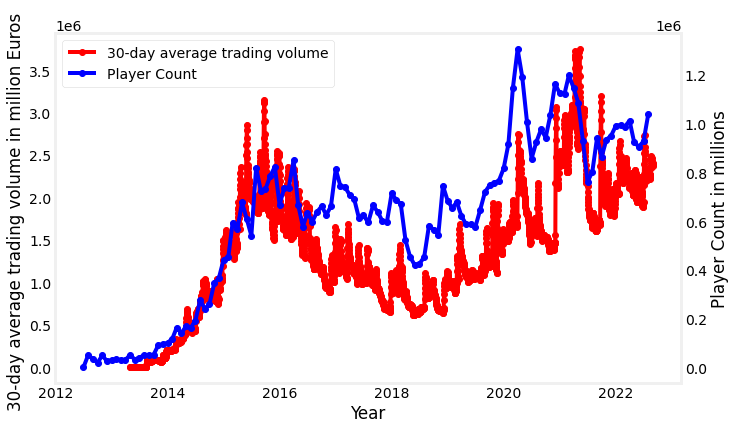

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('mathtext', default='regular')

time = np.arange(10)
temp = np.random.random(10)*30
Swdown = np.random.random(10)*100-10
Rn = np.random.random(10)*100-10

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_facecolor('white')
lns1 = ax.plot(market_cap['Date'], market_cap['Moving Average'], color='red', marker='o', label='30-day average trading volume')
ax2 = ax.twinx()
lns3 = ax2.plot(df_player['Date'], df_player["Player_Count"],color="blue",marker="o", label='Player Count')
# added these three lines
lns = lns1+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc='upper left',facecolor='white')
ax.set_facecolor('white')
ax.grid(False)
ax.set_xlabel("Year")
ax.set_ylabel(r"30-day average trading volume in million Euros ")
#ax.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
ax2.set_ylabel(r"Player Count in millions")
ax2.grid(False)
ax2.set_facecolor('white')
#ax2.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
plt.show()


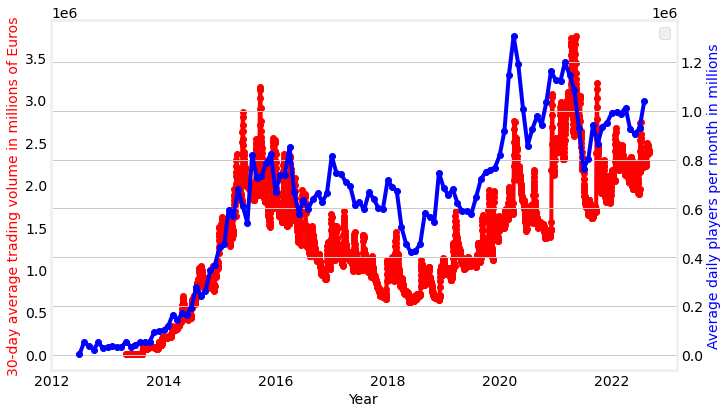

           Date  Moving Average
0    2013-04-26             NaN
1    2013-04-27             NaN
2    2013-04-28             NaN
3    2013-04-29             NaN
4    2013-04-30             NaN
...         ...             ...
3410 2022-08-27    2.389251e+06
3411 2022-08-28    2.398821e+06
3412 2022-08-29    2.402614e+06
3413 2022-08-30    2.410397e+06
3414 2022-08-31    2.369663e+06

[3415 rows x 2 columns]


In [ ]:
turnover=data.loc[data['Date']< '2022-09-01']
turnover['Turnover']=(data.Average_Price * data.Volume)
#turnover['Turnover_rolling']=turnover.groupby('Item')['Turnover'].rolling(window=7).mean()
market_cap=turnover.groupby('Date')['Turnover'].sum().rolling(window=7).mean().reset_index(name='Moving Average')
fig, ax= plt.subplots()
ax.plot(market_cap['Date'], market_cap['Moving Average'], color='red', marker='o') #market cap per day
#ax.set_title('30-day average trading volume in millions of Euros (red) versus player count in millions (blue)', fontsize=16,  fontweight='bold', pad=40)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('30-day average trading volume in millions of Euros', color="red", fontsize=14)
ax.grid(False)
#plt.show()
ax.set_facecolor('white')
fig.set_facecolor('white')
ax.legend(loc='upper right')

# twin object for two different y-axis on the sample plot
ax2=plt.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_player['Date'], df_player["Player_Count"],color="blue",marker="o")
ax2.set_ylabel("Average daily players per month in millions",color="blue",fontsize=14)
ax2.set_facecolor('white')
#ax2.grid(False)
#ax.legend()
ax2.legend(loc='upper right')
#ax2.legend(loc=0)
#axBS.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3,
           # fancybox=True, shadow=True)
plt.show()
# save the plot as a file
fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
            format='jpeg',
            dpi=100,
           bbox_inches='tight')
print(market_cap)


In [ ]:
day_per_week=turnover
day_per_week['Day_Per_Week']=day_per_week['Date'].dt.strftime('%A')
print(day_per_week)

In [ ]:
weekday=day_per_week.groupby('Day_Per_Week')['Turnover'].sum().reset_index(name='Sum').sort_values('Sum' , ascending=False)
print(weekday)

  Day_Per_Week           Sum
2     Saturday  7.224683e+08
0       Friday  7.068436e+08
3       Sunday  6.848559e+08
4     Thursday  6.448464e+08
6    Wednesday  6.392631e+08
1       Monday  6.316515e+08
5      Tuesday  6.215827e+08


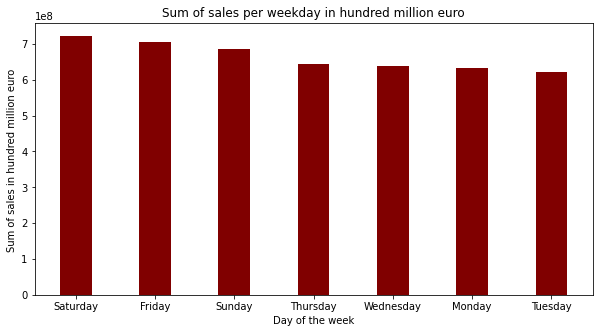

In [ ]:

#maybe average instead of sum

weekday=day_per_week.groupby('Day_Per_Week')['Turnover'].sum().reset_index(name='Sum').sort_values('Sum' , ascending=False)
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(weekday['Day_Per_Week'], weekday['Sum'], color ='maroon',
        width = 0.4)
 
plt.xlabel("Day of the week")
plt.ylabel("Sum of sales in hundred million euro ")
plt.title("Sum of sales per weekday in hundred million euro")
plt.show()

           Date  Counts
3315 2022-05-24   12072
3316 2022-05-25   12006
3317 2022-05-26   12165
3318 2022-05-27   12191
3319 2022-05-28   12024
...         ...     ...
3410 2022-08-27   12463
3411 2022-08-28   12483
3412 2022-08-29   12316
3413 2022-08-30   12357
3414 2022-08-31   12346

[100 rows x 2 columns]


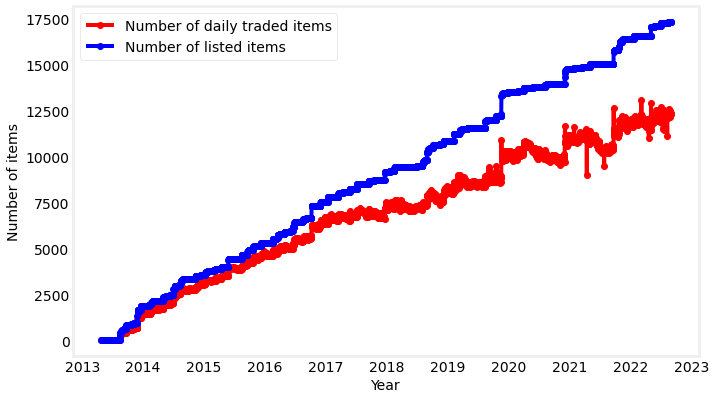

In [ ]:
import matplotlib.pyplot as plt
days_on_market=data.loc[data['Date']< '2022-09-01']
days_on_market=days_on_market.groupby('Date').size().reset_index(name='Counts')
market_size=result.groupby('Date').size().reset_index(name='Counts')
print(days_on_market.tail(100))
fig1 = plt.gcf()

plt.plot(days_on_market['Date'], days_on_market['Counts'], color='red', marker='o', label='Number of daily traded items') #traded items per day
plt.plot(market_size['Date'], market_size['Counts'], color='blue', marker='o', label='Number of listed items') #total items on market place
#plt.title('Numbers of daily items traded (red) versus total number of items (blue) per day', fontsize=16,  fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of items', fontsize=14)
plt.legend(facecolor='white')
plt.grid(False)
ax = plt.axes()
ax.set_facecolor('white')

#plt.legend([days_on_market['Counts'], market_size['Counts']], ['a', 'b'],loc='upper left')
#fig = plt.figure()
fig1.patch.set_facecolor('white')
#fig1.savefig('tessstttyyy.png', dpi=200)
#plt.setp(ax.spines.values(), color='black')
#plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')
plt.show()

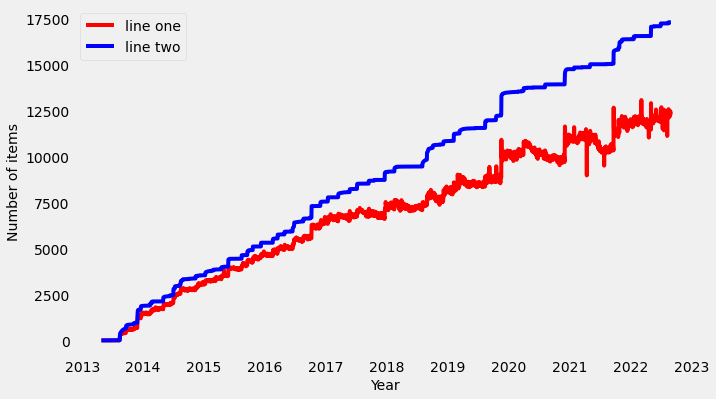

<Figure size 720x432 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(days_on_market['Date'], days_on_market['Counts'], color='red', label='line one')
plt.plot(market_size['Date'], market_size['Counts'], color='blue', label='line two')
plt.legend()
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of items', fontsize=14)
plt.grid(False)
fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_facecolor('white')
plt.show()

**Problem nicht jedes item wird jeden tag getraded z.B. StatTrak™ P250 | Red Rock (Well-Worn)**


**Scatter plots**

In [ ]:
data_days_on_market = pd.read_feather("data_final.feather")

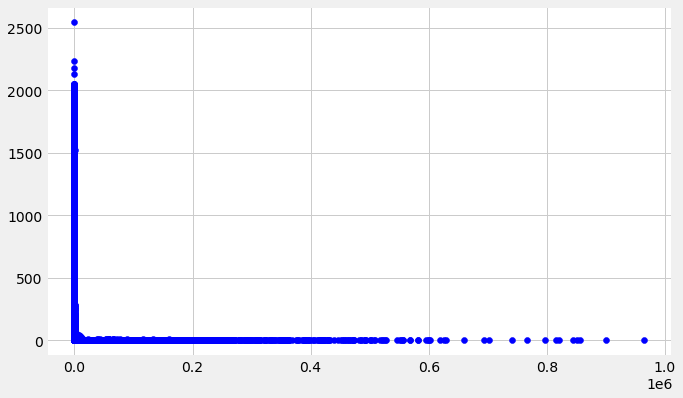

In [ ]:
plt.scatter(data['Volume'],data['Average_Price'], c ="blue") #change variable name in plot and size of volume ->scaler formatter, maybe log data
ax = plt.gca()
plt.title('Numbers of items traded (red) versus total number of items (blue) per day', fontsize=16,  fontweight='bold', pad=40)
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.patch.set_facecolor('white')
plt.grid(False)
plt.draw()

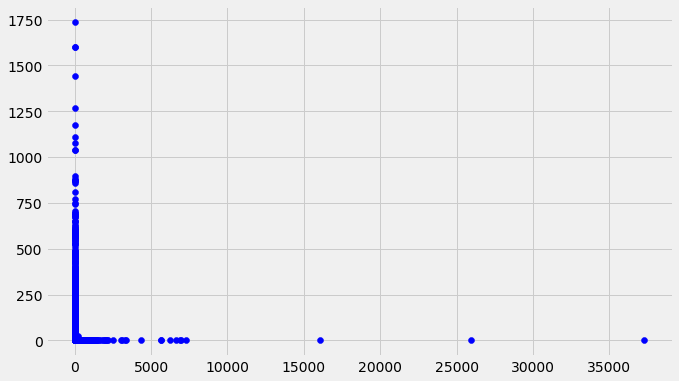

In [ ]:
data_statistics=data_days_on_market
data_statistics=data_statistics.groupby(['Item'])[['Average_Price_Min','Volume_Min']].min()

plt.scatter(data_statistics['Volume_Min'],data_statistics['Average_Price_Min'], c ="blue")
 
# To show the plot
plt.show()


In [ ]:
#Lieber die Daten (days_on_market) in blöcke einteilen und dann boxplot machen und mit volume
data_boxplot=data_days_on_market

conditions=[
    (data_boxplot['Days_On_Market'] <= 365),
    (data_boxplot['Days_On_Market'] >= 365) & (data_boxplot['Days_On_Market'] < 365*2),
    (data_boxplot['Days_On_Market'] >= 365*2) & (data_boxplot['Days_On_Market'] < 365*3),
    (data_boxplot['Days_On_Market'] >= 365*3) & (data_boxplot['Days_On_Market'] < 365*4),
    (data_boxplot['Days_On_Market'] >= 365*4) & (data_boxplot['Days_On_Market'] < 365*5),
    (data_boxplot['Days_On_Market'] >= 365*5)
    ]
categories=['< 1 year', '1-2 years', '2-3 years', '3-4 years', '4-5 years', '> 5 years' ]

data_boxplot['Days_On_Market_Category']=np.select(conditions, categories)
sns.boxplot(x='Days_On_Market_Category', y='Volume', data=data_boxplot)
print(data_boxplot)

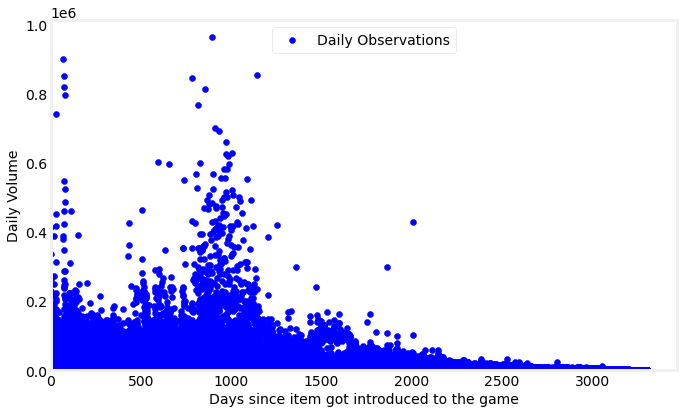

In [ ]:
data_statistics=data_days_on_market
fig1 = plt.gcf()
#data_statistics=data_statistics.groupby(['Item'])[['Average_Price_Min','Volume_Min']].min()
plt.scatter(data_statistics['Days_On_Market'],data_statistics['Volume'], c ="blue", label='Daily Observations')
#plt.title('Numbers of items traded (red) versus total number of items (blue) per day', fontsize=16,  fontweight='bold', pad=20)
plt.xlabel('Days since item got introduced to the game', fontsize=14)
plt.ylabel('Daily Volume', fontsize=14)
plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
plt.grid(False)
plt.legend(facecolor='white', loc='upper center')
ax = plt.axes()
ax.set_facecolor('white')
fig1.patch.set_facecolor('white')
plt.xlim([0, None])
plt.ylim([0, None])


#plt.setp(ax.spines.values(), color='grey')
#plt.setp([ax.get_xticklines(), ax.get_yticklines()], color='black')
# To show the plot
plt.show()


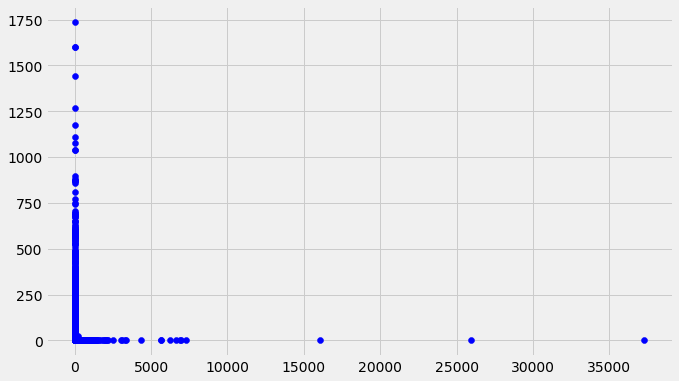

                                               Average_Price_Min  Volume_Min
Item                                                                        
'Blueberries' Buckshot | NSWC SEAL                         0.862        50.0
'Medium Rare' Crasswater | Guerrilla Warfare               4.512        38.0
'The Doctor' Romanov | Sabre                               2.027         8.0
'Two Times' McCoy | TACP Cavalry                           0.643        61.0
'Two Times' McCoy | USAF TACP                              0.683         2.0
...                                                          ...         ...
★ Ursus Knife | Urban Masked (Battle-Scarred)             59.375         1.0
★ Ursus Knife | Urban Masked (Factory New)               112.817         1.0
★ Ursus Knife | Urban Masked (Field-Tested)               57.307         1.0
★ Ursus Knife | Urban Masked (Minimal Wear)               84.855         1.0
★ Ursus Knife | Urban Masked (Well-Worn)                  17.260         1.0

In [ ]:
data_statistics=data_days_on_market
data_statistics=data_statistics.groupby(['Item'])[['Average_Price_Min','Volume_Min']].min()

plt.scatter(data_statistics['Volume_Min'],data_statistics['Average_Price_Min'], c ="blue")
 
# To show the plot
plt.show()

print(data_statistics)



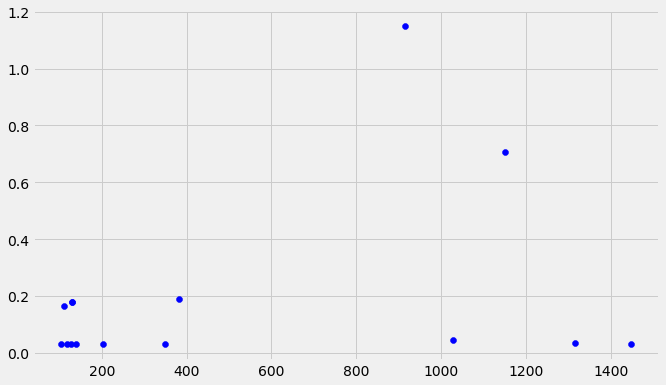

In [ ]:
data_statistics_filter=data
data_statistics_filter=data_statistics_filter.groupby(['Item'])[['Average_Price_Min','Volume_Min']].min()
data_statistics_filter=data_statistics_filter[(data_statistics_filter['Volume_Min'] > 100) & (data_statistics_filter['Volume_Min'] < 5000)]
plt.scatter(data_statistics_filter['Volume_Min'],data_statistics_filter['Average_Price_Min'], c ="blue")
 
#To show the plot
plt.show()

In [ ]:
data_statistics_overview=data
data_statistics_overview=data_statistics_overview.groupby(['Item'])[['Average_Price_Min','Volume_Min']].min()
data_statistics_overview['Price_category'] = pd.cut(data_statistics_overview['Average_Price_Min'], bins=[0, 10, 50, float('Inf')], labels=['Price < 10$', 'Price 10$ - 50$', 'Price > 50$'])
data_statistics_overview['Volume_category'] = pd.cut(data_statistics_overview['Volume_Min'], bins=[0, 100, 1000, float('Inf')], labels=['Vol < 100 ', 'Vol 100 - 1000 ', 'Item > 1000 '])
overview = pd.crosstab(index=data_statistics_overview['Price_category'], 
                            columns=data_statistics_overview['Volume_category'],
                             margins=True)   
overview.index=['Price < 10$', 'Price 10$ - 50$', 'Price > 50$', 'coltotal']
overview.columns = ['Vol < 100 ', 'Vol 100 - 1000 ', 'Item > 1000 ', 'rowtotal']


overview

,Vol < 100,Vol 100 - 1000,Item > 1000,rowtotal
Price < 10$,14710,11,4,14725
Price 10$ - 50$,1220,0,0,1220
Price > 50$,1376,0,0,1376
coltotal,17306,11,4,17321


**Trying to find the best arima model for each product**

**Split data into train and test sets and let autoarima find the best arima model**

In [ ]:
data_arima=data
product_list=data_arima.drop_duplicates(subset='Item', keep="last")
product_list=product_list.drop(['index','Date','Average_Price','Volume'], axis=1)
product_list=product_list.head(1)
product_list=product_list['Item'].values.tolist()

for i in product_list:
    arima_single=data_arima[data_arima['Item']==i]
    arima_single=arima_single['Average_Price']
    #print(arima_single)
    train_data, test_data = arima_single[3:int(len(arima_single)*0.9)], arima_single[int(len(arima_single)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Closing Prices')
    plt.plot(arima_single, 'green', label='Train data')
    plt.plot(test_data, 'blue', label='Test data')
    plt.legend()


    model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    print(model_autoARIMA.summary())
    model_autoARIMA.plot_diagnostics(figsize=(15,8))
    plt.show()

In [ ]:
print(dates.head(100))

NameError: ignored

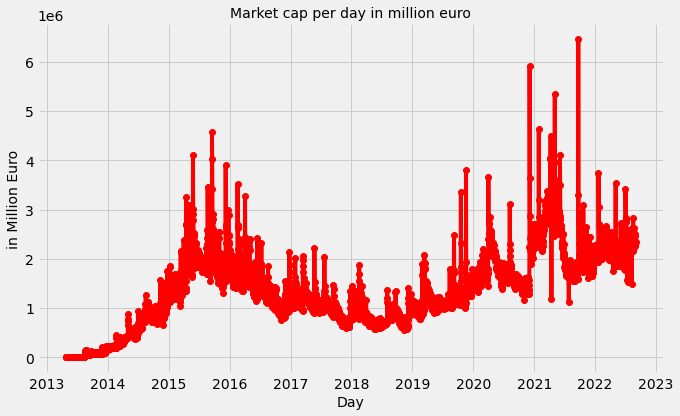

In [ ]:
turnover=data.loc[data['Date']< '2022-09-01']
turnover['Turnover']=(data.Average_Price * data.Volume)
market_cap=turnover.groupby('Date')['Turnover'].sum().reset_index(name='Sum')

plt.plot(market_cap['Date'], market_cap['Sum'], color='red', marker='o') #market cap per day
plt.title('Market cap per day in million euro', fontsize=14)
plt.xlabel('Day', fontsize=14)
plt.ylabel('in Million Euro', fontsize=14)
plt.grid(True)
plt.show()
